In [1]:
!pip install opencv-python
!pip install matplotlib
!pip install numpy
!pip install sklearn
!pip install mediapipe
!pip install numba
!pip install tqdm
apt install libgl1-mesa-glx

     |████████████████████████████████| 49.5 MB 17.4 MB/s eta 0:00:01
     |████████████████████████████████| 11.6 MB 4.1 MB/s eta 0:00:01    |█████████████████               | 6.2 MB 4.1 MB/s eta 0:00:02
     |████████████████████████████████| 1.1 MB 22.9 MB/s eta 0:00:01
     |████████████████████████████████| 2.2 MB 24.6 MB/s eta 0:00:01
     |████████████████████████████████| 6.8 MB 4.5 MB/s eta 0:00:01
     |████████████████████████████████| 301 kB 18.0 MB/s eta 0:00:01
     |████████████████████████████████| 25.9 MB 11.9 MB/s eta 0:00:01
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1316 sha256=aa3b49c1e9db054358d1b9a14a5269d26e524d1a5d88bd0eb360200606595759
  Stored in directory: /root/.cache/pip/wheels/23/9d/42/5ec745cbbb17517000a53cecc49d6a865450d1f5cb16dc8a9c
Successfully built sklearn
     |████████████████████████████████| 34.5 MB 7.7 MB/s eta 0:00:012     |██████████████████              | 19.4 MB 10.3 MB/s eta 0:00:02
     |██████████████████

# Imports 

In [3]:
import numpy as np
from datetime import date
import tensorflow as tf
import math
import sklearn
import os
import cv2
import matplotlib.pyplot as plt
import sklearn.metrics
from tqdm.notebook import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
import dlib

## Utils 

In [4]:
def image_to_face_landmarks(image):
    mp_drawing = mp.solutions.drawing_utils
    mp_face_mesh = mp.solutions.face_mesh
    face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True,max_num_faces=1,min_detection_confidence=0.001)
    drawing_spec = mp_drawing.DrawingSpec(thickness=1, circle_radius=2)
    results = face_mesh.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    annotated_image = image.copy()
#     print(results.multi_face_landmarks)
    for face_landmarks in results.multi_face_landmarks:
        mp_drawing.draw_landmarks(image=annotated_image,landmark_list=face_landmarks,connections=mp_face_mesh.FACE_CONNECTIONS,landmark_drawing_spec=drawing_spec,connection_drawing_spec=drawing_spec)
    face_mesh.close()
    return annotated_image,face_landmarks.landmark

# annotated_image,landmarks = image_to_face_landmarks(cv2.imread('FER//validation//ang//0.jpg'))

def face_landmarks_to_euclid_image(face_landmarks):
    temp = np.zeros((468,2))
    for i in range(len(face_landmarks)):
        landmark=face_landmarks[i]
        temp[i]=np.array([landmark.x,landmark.y])
    pairwise = sklearn.metrics.pairwise_distances(temp)
    return pairwise

# plt.imshow(face_landmarks_to_euclid_image(landmarks))

In [5]:
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')

In [130]:
%%writefile utils.py

import numpy as np
from datetime import date
import tensorflow as tf
import math
import sklearn
import os
import cv2
import matplotlib.pyplot as plt
import sklearn.metrics
from tqdm.notebook import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
import dlib

def rect_to_bb(rect):
    x=rect.left()
    y=rect.top()
    w=rect.right()  -x 
    h=rect.bottom() -y
    return (x,y,w,h)

def shape_to_numpy(shape,dtype='int'):
    coords = np.zeros((68,2) , dtype=dtype)
    for i in range(0,68):
        coords[i] = (shape.part(i).x,shape.part(i).y)
        
    return coords

def align_face(image,dim,features):
    '''
    Align face image given features array in shape of 68,2
    '''
    top_nose  = features[28,:]
    left_eye  = features[37:41,:]
    right_eye = features[43:46,:]
    dx,dy     =  np.mean(right_eye,axis=0).astype('int') - np.mean(left_eye,axis=0).astype('int')
    angle     = np.degrees(np.arctan2(dy, dx))
    M         = cv2.getRotationMatrix2D((top_nose[0],top_nose[1]), angle, 1)
    return  cv2.warpAffine(image, M, dim,flags=cv2.INTER_CUBIC)

def image_to_crop_feature(image,dim=(28,28),detector=None,predictor=None):
    '''
    Input:  image
    Output: 
        1- cropped video numpy array (row,col,channel) , 
        2- facial features array (68,2,1)
    '''
    try:
        rects = detector(image)
    
        (x0,y0,w,h)= rect_to_bb(list(rects)[0])
    except :
        x0,y0,w,h=0,0,image.shape[1],image.shape[0]
    crop  = cv2.resize(image[y0:y0+h,x0:x0+h], dim, interpolation = cv2.INTER_AREA)
    shape = predictor(crop,dlib.rectangle(left=0, top=0, right=dim[0], bottom=dim[1]))
    shape = shape_to_numpy(shape)
    crop  = align_face(crop,dim,shape)
    shape = predictor(crop,dlib.rectangle(left=0, top=0, right=dim[0], bottom=dim[1]))
    shape = shape_to_numpy(shape)    
    return  crop,shape.reshape(1,68,2,1)


def transform_emotion_to_integer(emotion):
    emotions ={'ang': 0, 'dis': 1, 'fea': 2, 'hap': 3, 'neu': 4, 'sad': 5, 'sur': 6}
#     emotions = ['hap','sur','fea','neu','sad','dis','ang']
    return emotions(emotion)

def transform_integer_to_emotion(integer):
    emotions = {0: 'ang', 1: 'dis', 2: 'fea', 3: 'hap', 4: 'neu', 5: 'sad', 6: 'sur'}
    return emotions[integer]


def create_euclid_matrix(array):
    '''
    Input : (frames,68,2,1) landmark tensor
    output : (frames,68,68,1) tensor of pairwise distance
    '''
    temp =np.zeros((1,array.shape[0],68,68,1))
    for fi in range(array.shape[0]):
        temp[0,fi,:,:,0] = sklearn.metrics.pairwise_distances(array[fi,:,:,0])
    return temp


def features_to_image(image,features):
    for (x,y) in features[0,:,:,0]:image = cv2.circle(image,(x,y),1,(255,255,255))
    return image

Writing utils.py


In [90]:
train_generator.class_indices

{'ang': 0, 'dis': 1, 'fea': 2, 'hap': 3, 'neu': 4, 'sad': 5, 'sur': 6}

In [22]:
emos = os.listdir('train')
for emo in emos:
    files = os.listdir(f'train//{emo}')
    for file in tqdm(range(len(files))):
        image = cv2.imread(f'train//{emo}//{files[file]}')
#         cv2.imshow('text',image);cv2.waitKey(1)
    #     try:
        crop , features = image_to_crop_feature(image,dim=(68,68),detector=detector,predictor=predictor)
        euclid = create_euclid_matrix(features)
    #     break
        cv2.imwrite(f'train_euc//{emo}/{files[file]}',euclid[0,0,:,:,0])
    #     print('done',file,end='\r')
    #     except :
    #         print(f'error at {file}',end='\r')

## Model

In [129]:
%%writefile model.py


def build_model(shape=(68,68,1)):
    '''
    '''
    input = Input(shape)
    x = Conv2D(16,(2,2),padding='same',activation=LeakyReLU())(input)
    x = Conv2D(1,(2,2),padding='same',activation=LeakyReLU())(x)
    x = Flatten()(x)
    x = Dense(2048,activation='linear')(x)
    x = Dense(2048,activation='linear')(x)
    x = Dense(2048,activation='linear')(x)
    x = Dropout(0.25)(x)
    output = Dense(7, activation='softmax')(x)
    model = Model(input, output)
    optimizer = Adam(learning_rate=1e-3)
    model.compile(loss='categorical_crossentropy',optimizer=optimizer,metrics=['accuracy'])
    return model


Writing model.py


## Callbacks

In [12]:
def create_callbacks(filepath_model,monitor='val_accuracy'):
    model_checkpoint_callback = tensorflow.keras.callbacks.ModelCheckpoint(filepath=filepath_model,save_weights_only=False,monitor=monitor,mode='auto',save_best_only=True)
    reduce_lr_callback = tensorflow.keras.callbacks.ReduceLROnPlateau(monitor = monitor,factor = 0.5,patience = 5,verbose = 1,min_delta = 0.0001)
    csv_callback= tensorflow.keras.callbacks.CSVLogger('train.log')
    return [model_checkpoint_callback,reduce_lr_callback,csv_callback]

## Generators

In [14]:
def create_generators(size=(68,68),\
                      train_images_directory ='',\
                      validation_images_directory='',\
                      batch_size =32) :


    train_images_generator = ImageDataGenerator(rescale=1/255.0)
    validation_images_generator = ImageDataGenerator(rescale=1/255.0)

    train_generator = train_images_generator.flow_from_directory(
                    train_images_directory,
                    target_size = (size[0],size[1]),
                    batch_size  = batch_size ,
                    color_mode  = 'grayscale' , 
                    class_mode  = 'categorical' ,
                    shuffle     = True
                                                                )

    validation_generator = train_images_generator.flow_from_directory(
                    validation_images_directory,
                    target_size = (size[0],size[1]),
                    batch_size  = batch_size ,
                    color_mode  = 'grayscale' , 
                    class_mode  = 'categorical' ,
                    shuffle     = True
                                                            )
    return train_generator ,validation_generator

## Wrap up

In [24]:
train_generator,validation_generator = create_generators(size=(68,68),\
                                                         train_images_directory ='train_euc',\
                                                         validation_images_directory='validation_euc',\
                                                         batch_size =32 )

Found 28709 images belonging to 7 classes.
Found 3589 images belonging to 7 classes.


In [25]:
train_count  = 28709
validation_count= 3589
batch_size = 32

In [31]:
model = build_model()
callbacks= create_callbacks(filepath_model=f'euc-model-29-11.h5')
model.fit(
            train_generator,
            steps_per_epoch = train_count //batch_size,
            epochs = 100,
            callbacks = callbacks,
            validation_data=validation_generator,
            validation_steps = validation_count//batch_size
        )

Epoch 1/100
897/897 [==============================] - 17s 19ms/step - loss: 1.7237 - accuracy: 0.3100 - val_loss: 1.6466 - val_accuracy: 0.3527
Epoch 2/100
897/897 [==============================] - 16s 18ms/step - loss: 1.5440 - accuracy: 0.4030 - val_loss: 1.6273 - val_accuracy: 0.3912
Epoch 3/100
897/897 [==============================] - 16s 18ms/step - loss: 1.4979 - accuracy: 0.4271 - val_loss: 118.0558 - val_accuracy: 0.1155
Epoch 4/100
897/897 [==============================] - 16s 18ms/step - loss: 13.8134 - accuracy: 0.2925 - val_loss: 1.5697 - val_accuracy: 0.3803
Epoch 5/100
897/897 [==============================] - 16s 18ms/step - loss: 1.4230 - accuracy: 0.4572 - val_loss: 1.5954 - val_accuracy: 0.3708
Epoch 6/100
897/897 [==============================] - 16s 18ms/step - loss: 1.4155 - accuracy: 0.4558 - val_loss: 1.5959 - val_accuracy: 0.3982
Epoch 7/100
897/897 [==============================] - 16s 18ms/step - loss: 1.3993 - accuracy: 0.4634 - val_loss: 1.6175 - val

In [43]:
!wget "https://www.pngkey.com/png/detail/108-1089836_baby-crying-png-background-image-sad-face-human.png"

--2020-11-28 19:44:15--  https://www.pngkey.com/png/detail/108-1089836_baby-crying-png-background-image-sad-face-human.png
Resolving www.pngkey.com (www.pngkey.com)... 204.12.208.124
Connecting to www.pngkey.com (www.pngkey.com)|204.12.208.124|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 102663 (100K) [image/png]
Saving to: ‘108-1089836_baby-crying-png-background-image-sad-face-human.png’

108-1089836_baby-cr 100%[===================>] 100.26K   465KB/s    in 0.2s    

2020-11-28 19:44:16 (465 KB/s) - ‘108-1089836_baby-crying-png-background-image-sad-face-human.png’ saved [102663/102663]



In [136]:
def pipeline(image,detector,predictor,model):
    '''
    input : image 
    output : emotion
    '''
    crop , features = image_to_crop_feature(image,dim=(68,68),detector=detector,predictor=predictor)
    euclid = create_euclid_matrix(features)
    predictions = model.predict(euclid[0]/255.0)
    return transform_integer_to_emotion(np.argmax(predictions))

In [142]:
pipeline(cv2.imread('test3.jpg'),detector=detector,predictor=predictor,model=model)

'hap'

## Test image

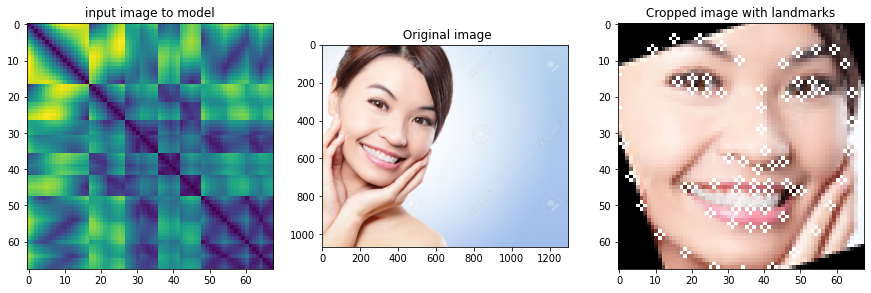

In [150]:
img = cv2.imread('test3.jpg')
crop , features = image_to_crop_feature(img,dim=(68,68),detector=detector,predictor=predictor)
euclid = create_euclid_matrix(features)

plt.figure(figsize=(15,15))
plt.subplot(1,3,1);plt.imshow(euclid[0,0,:,:,0]/255);plt.title("input image to model")
plt.subplot(1,3,2);plt.imshow(np.flip(img,2));plt.title(" Original image")
plt.subplot(1,3,3);plt.imshow(np.flip(features_to_image(crop.copy(),features),2));plt.title("Cropped image with landmarks")
plt.savefig('demo.png')

In [125]:
model.evaluate(validation_generator)

113/113 [==============================] - 2s 16ms/step - loss: 1.9871 - accuracy: 0.3968


[1.9870843887329102, 0.39676791429519653]

In [126]:
model.evaluate(train_generator)

898/898 [==============================] - 15s 16ms/step - loss: 0.9815 - accuracy: 0.6372


[0.98145991563797, 0.6372217535972595]